In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
epoch_key = ('chimi', 5, 2) # animal, day, epoch

In [4]:
from src.load_data import load_data


data = load_data(epoch_key)

17-Jan-21 16:34:13 Loading position information and linearizing...
17-Jan-21 16:34:16 Loading multiunits...
17-Jan-21 16:34:31 Loading theta...


In [24]:
from replay_trajectory_classification import ClusterlessClassifier


classifier = classifier.load_model(f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_model.pkl")
classifier

ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform'],
                                                   ['uniform', 'uniform']],
                      discrete_transition_diag=0.968,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=2.5, position_range=None, replay_speed=1)

In [10]:
import xarray as xr


results = xr.open_dataset('chimi_05_02_results.nc')
results

<xarray.Dataset>
Dimensions:            (position: 221, state: 2, time: 655622)
Coordinates:
  * time               (time) float64 2.36e+03 2.36e+03 ... 3.672e+03 3.672e+03
  * position           (position) float64 1.197 3.592 5.986 ... 641.0 643.4
  * state              (state) object 'Continuous' 'Fragmented'
Data variables:
    likelihood         (time, state, position) float64 ...
    causal_posterior   (time, state, position) float64 ...
    acausal_posterior  (time, state, position) float64 ...

In [13]:
from trajectory_analysis_tools import (get_ahead_behind_distance,
                                       get_trajectory_data)

posterior = results.acausal_posterior.sum("state")

trajectory_data = get_trajectory_data(
    posterior,
    data['track_graph'],
    classifier,
    data['position_info'])

ahead_behind_distance = get_ahead_behind_distance(
    data['track_graph'], *trajectory_data)

In [18]:
ahead_behind_distance

array([-213.49378147, -215.9789781 , -213.57742829, ...,    5.77569732,
          5.7752428 ,    5.77478827])

In [14]:
from trajectory_analysis_tools import get_highest_posterior_threshold, get_HPD_spatial_coverage

hpd_threshold = get_highest_posterior_threshold(posterior, coverage=0.95)
spatial_coverage = get_HPD_spatial_coverage(posterior, hpd_threshold)

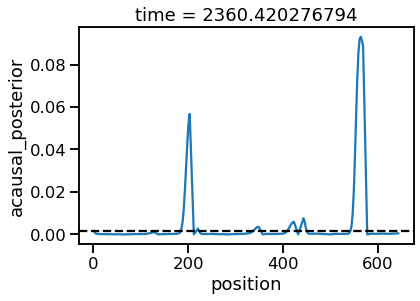

In [23]:
posterior.isel(time=0).plot(x='position')
plt.axhline(hpd_threshold[0], color='black', linestyle='--')

In [16]:
pwd

'/stelmo/edeno/ac_clusterless_decoding/notebooks'

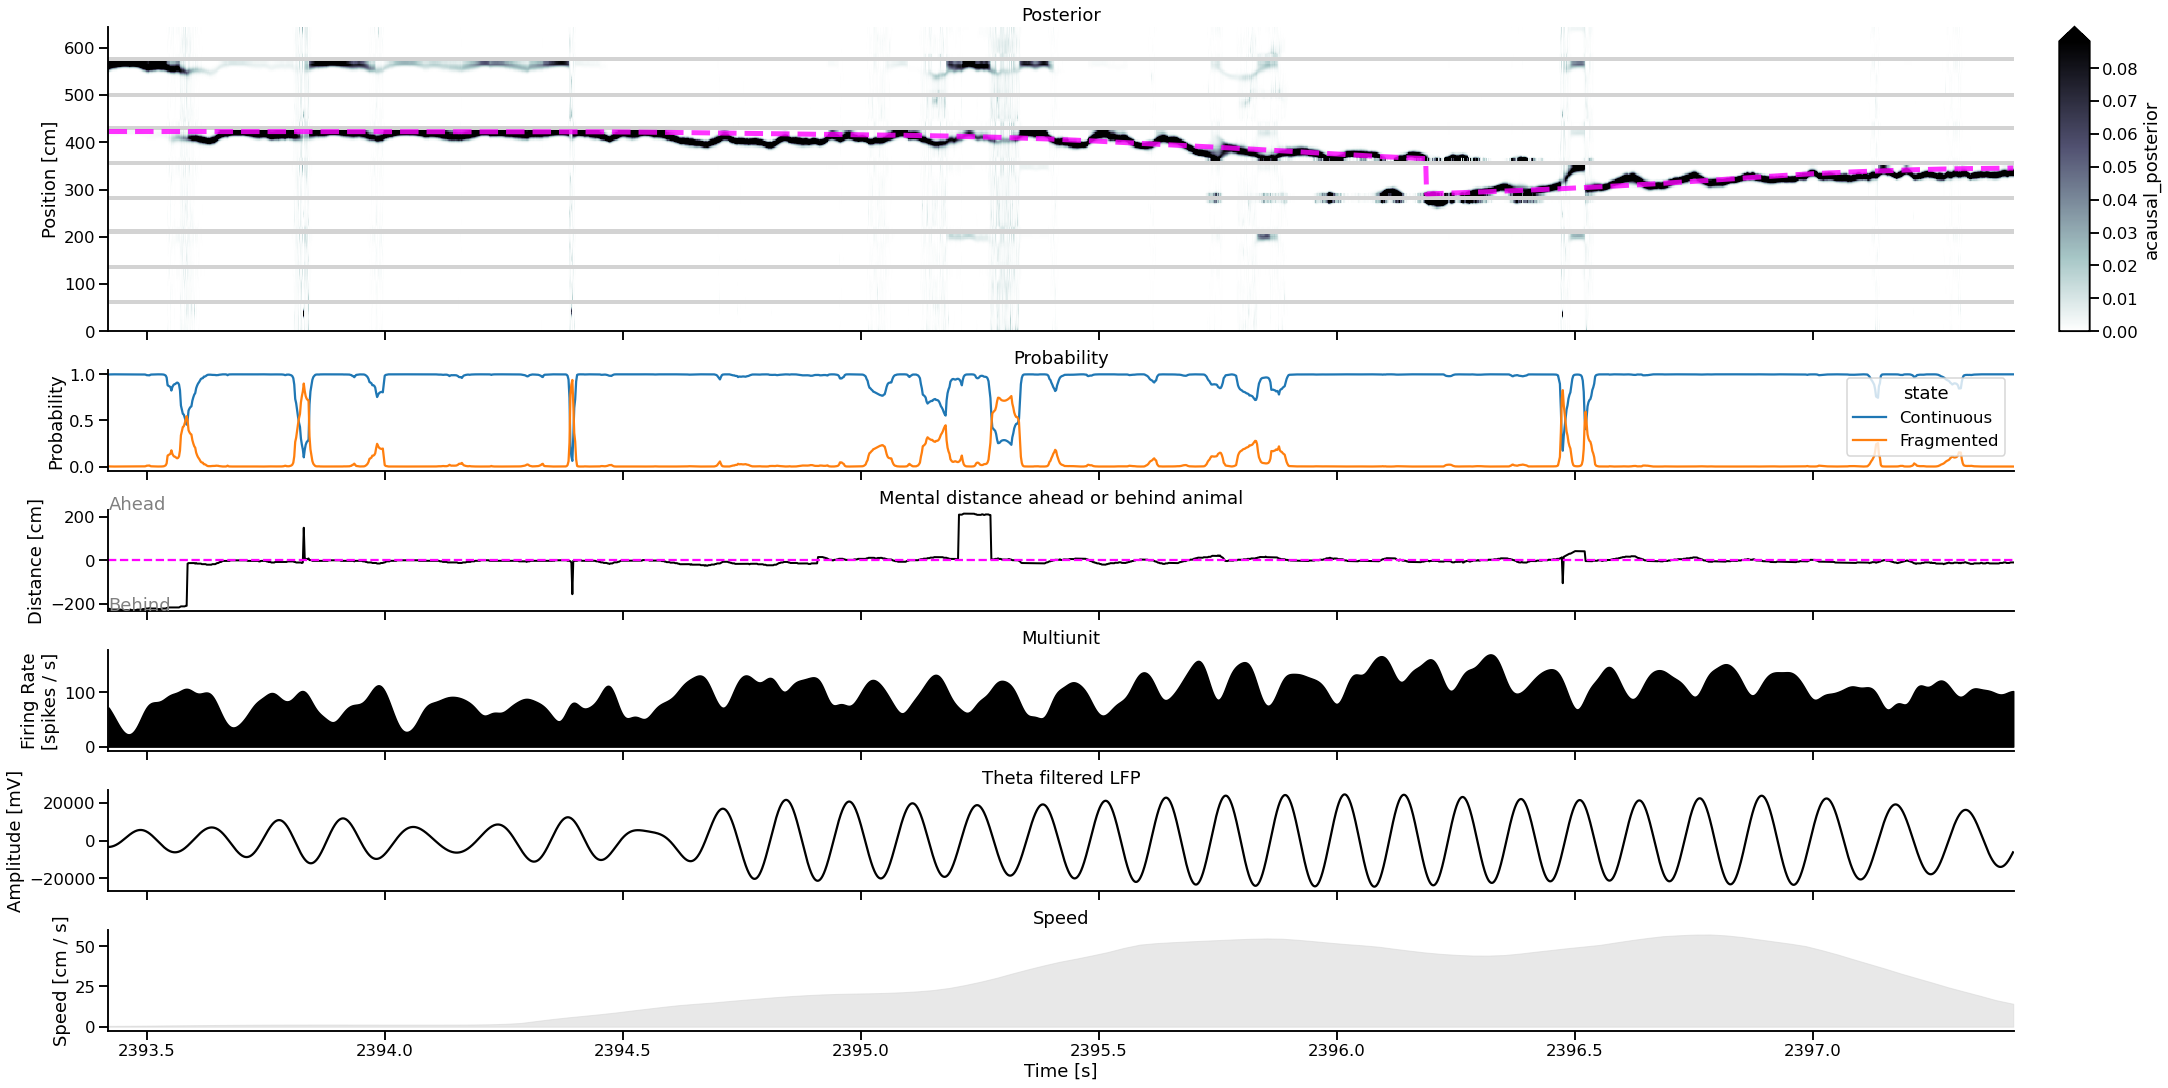

In [26]:
from src.visualization import plot_classifier_time_slice

time = results.time.values
time_slice = slice(time[16500], time[18500])

plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
)